# Quantum computing and materials science: A practical guide to applying quantum annealing to the configurational analysis of materials

This notebook contains the data used in the paper: B.Camino et al. "Quantum computing and materials science: A practical guide to applying quantum annealing to the configurational analysis of materials".

In [5]:
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
import numpy as np
import pandas as pd

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter

from ase.visualize import view

import dataframe_image as dfi

import sys
import os
import copy
sys.path.insert(1,'/Users/brunocamino/Desktop/Imperial/crystal-code-tools/CRYSTALpytools/CRYSTALpytools/')
from crystal_io import *
from convert import *
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')



## Build the graphene supercell

In [2]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

n_supercell = 3
scaling_matrix = np.identity(3)*n_supercell
scaling_matrix[2][2] = 1
graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
graphene_supercell.num_sites

18

# Loop

In [136]:
directory = ['one_vacancy','two_vacancy','three_vacancy']
for ratio_1 in range(1,2):
    for ratio in [ratio_1]*2:
        for vac in [1]:
            structure = graphene_supercell
            use_coord = False
            num_vacancies= vac
            alpha = 1*ratio
            beta = 0
            lambda_1 =  2*ratio
            num_reads = 1000
            file_path = 'data/paper/convergence/solution_symmetry/%s/'%directory[vac-1]
            file_name = 'graphene'
            remove_broken_chains = False

            bqm = build_quadratic_model(structure,use_coord=use_coord,alpha=alpha,beta=beta,
                                         lambda_1=lambda_1, num_vacancies=num_vacancies)

            chain_strength = uniform_torque_compensation(bqm,prefactor=0.3)

            #for chain_strength in [uniform_torque_compensation(bqm,prefactor=i) for i in np.arange(0.1,1.1,0.1)]:
            #for time in [1,2,5,10,20,50,100]:
            sampleset = run_anneal(bqm,dataframe = False, num_reads=num_reads, 
                                                       return_config_E=False,remove_broken_chains=remove_broken_chains,
                                      chain_strength=chain_strength)#, annealing_time=float(time))


                #save bqm
            save_json(structure,sampleset,bqm,use_coord=use_coord, num_vacancies=num_vacancies, 
              weight_1=alpha, weight_2=beta, lagrange=lambda_1, num_reads=num_reads,
              remove_broken_chains = remove_broken_chains,
              file_path=file_path, file_name=file_name, chain_strength=chain_strength)


Unconstrained quadratic model + contraints used
Unconstrained quadratic model + contraints used


# The QUBO model
The QUBO model used in this Section is:
$$
        \mathbf{U} = \underbrace{
        \alpha \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} - A_{i,j} x_{i} x_{j}
        }_\text{broken bonds objective}
        +  
        \underbrace{
        \beta \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} - B_{i,j} x_{i} x_{j}
        }_\text{coordination objective}
        +
        \underbrace{
        \lambda
        \left(
        \sum_{i}^{N_{sites}} \left(1-2N_{C}\right) x_{i} +
        \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} 2 x_{i} x_{j}
        \right)
        }_\text{constraint} = \\
        \lambda \sum_{i}^{N_{sites}} \left(1-2N_{C}\right) x_{i} +
        \sum_{i}^{N_{sites}}\sum_{j>i}^{N_{sites}} \left(2\lambda - \alpha A_{i,j} - \beta B_{i,j} \right) x_{i} x_{j}
$$

where $N_{sites}$ is the number of sites in the graphene supercell and $N_{C}$ is the number of Carbon atoms. 

$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j} - \beta B_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$

# Tuning the parameters
In this Section of the Notebook, we will tune the following parameters:
- $\alpha$/$\lambda$ ratio
- the chain strength 
- the annealing time

These are evaluate by plotting:
- the % of broken chains
- the % of feasible solutions ($i.e.$, the ones that respect the constraint)
- the % of states ($i.e.$, the ratio of lowest energy and higher energy constraint-resepcting solutions)

# Ratio alpha lambda

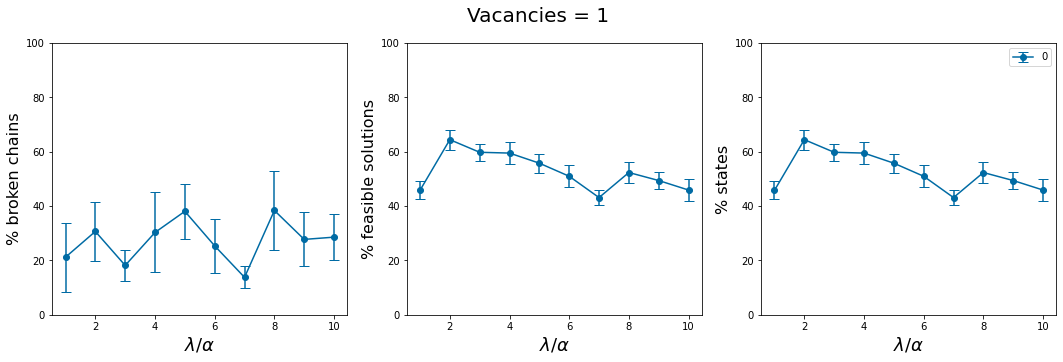

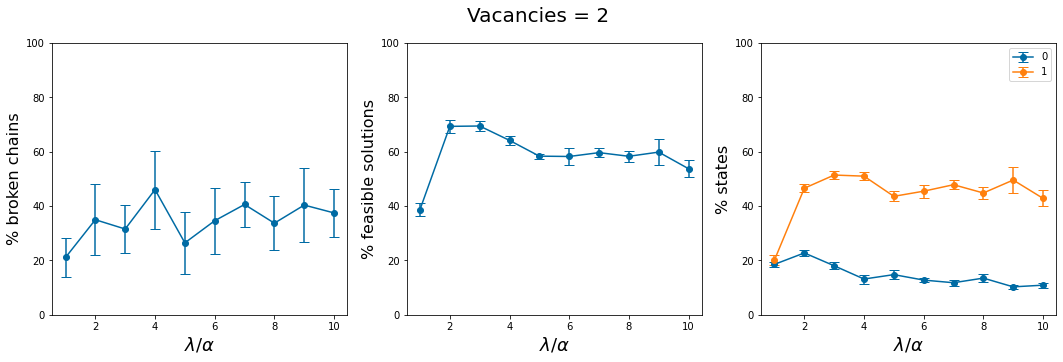

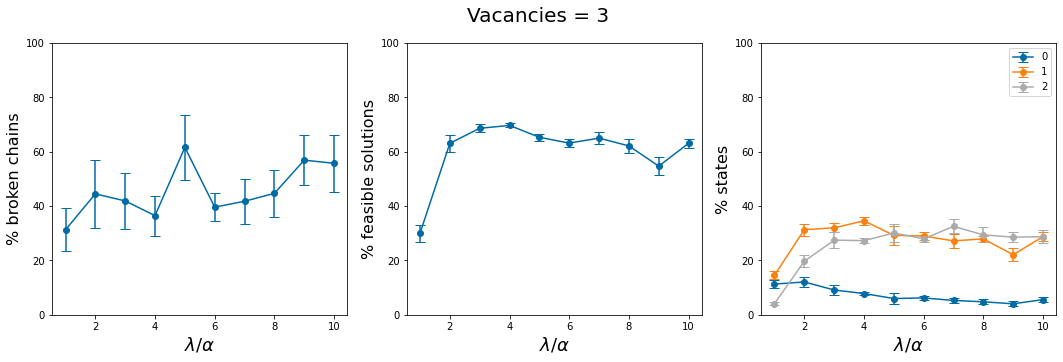

In [367]:
directory_main = './data/paper/convergence/alpha_lambda/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = range(1,11)

for i,vac in enumerate([1,2,3]):    
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for ratio in range(1,11):
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_l%s_'%ratio in f:
                df, param = load_json(f,return_param = True, return_qubo = False)
                ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                ratio_feasible_tmp.append(find_ratio_feasible(df,vac)*100)
                energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
                    
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))
        #print(ratio,energy_distribution_tmp)
        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
        
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=16)
    axs[1].set_ylabel('% feasible solutions', fontsize=16)
    axs[2].set_ylabel('% states', fontsize=16)
    
    axs[2].legend()
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/alpha_lamdba_graphs_%s.png'%str(vac),dpi=200)

# Chain strength

In [2]:
directory_main = './data/paper/convergence/chain_strength/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

#to make sure the lowest chain strength return results
unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

x = [uniform_torque_compensation(bqm,prefactor=i) for i in np.arange(0.1,1.1,0.1)]

for i,vac in enumerate([1,2,3]):
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for prefactor in np.arange(0.1,1.1,0.1):
        chain_strength = uniform_torque_compensation(bqm,prefactor=prefactor)
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        energy_distribution_2_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json"):
                df, param = load_json(f,return_param = True, return_qubo = False)
                if np.round(float(param.loc['chain_strength']),5) == np.round(chain_strength,5):
                    #print(chain_strength)
                    ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                    ratio_feasible_tmp.append(find_ratio_feasible(df,vac)*100)
                    #print(find_energy_distribution(df,only_feasible=True,vacancies=vac)[0])
                    #print(find_energy_distribution(df,only_feasible=True,vacancies=vac)[1])
                    energy_distribution_2_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[0]))
                    energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
        #unique_energy = np.unique(np.array([item for sublist in energy_distribution_2_tmp for item in sublist]))

        for k,energy in enumerate(unique_energies[i]):
            for m,energy_list in enumerate(energy_distribution_2_tmp):
                if energy not in energy_list:
                    energy_distribution_tmp[m].insert(k,0)
        #print(energy_distribution_tmp)    
        
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))
        #print(chain_strength,energy_distribution_tmp)
        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
    
    
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=14)
    axs[1].set_ylabel('% feasible solutions', fontsize=14)
    axs[2].set_ylabel('% states', fontsize=14)
      
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel("chain strength", fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/chain_strength_graphs_%s.png'%str(vac),dpi=200)

NameError: name 'bqm' is not defined

# Annealing time

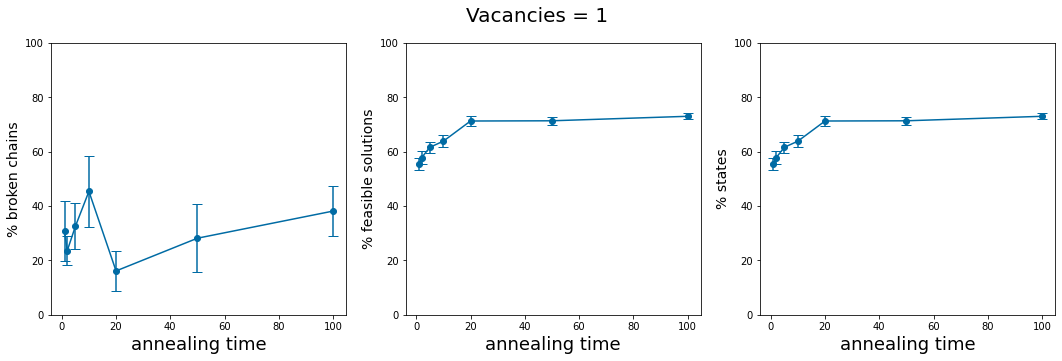

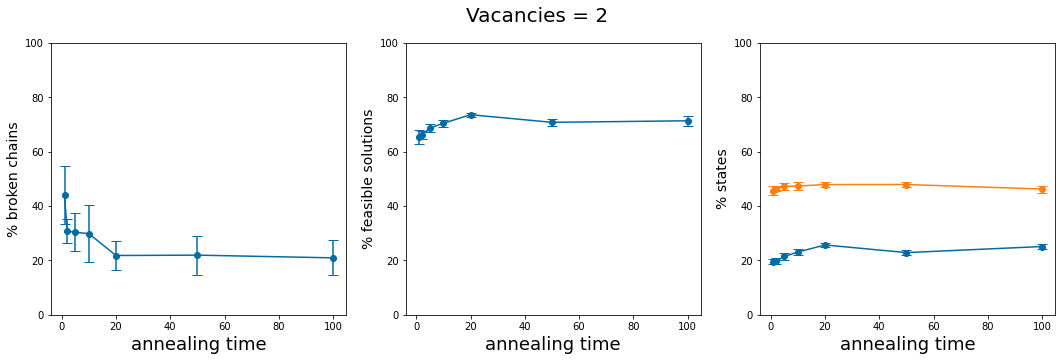

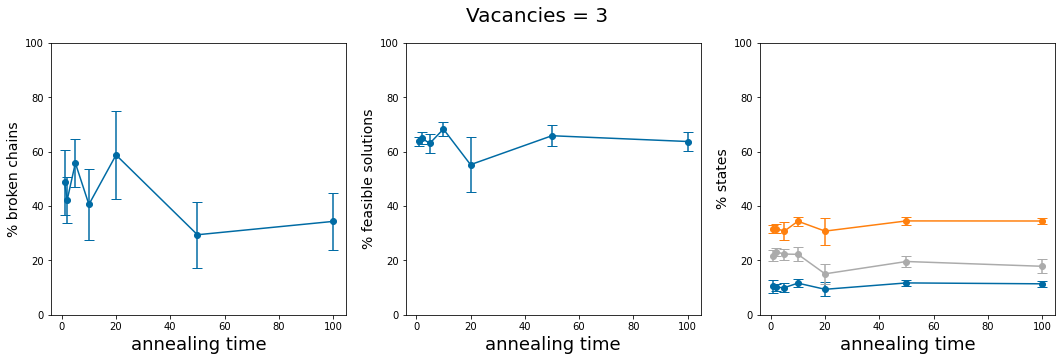

In [25]:
directory_main = './data/paper/convergence/anneal_time/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

#to make sure the lowest chain strength return results
unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]

x = [1,2,5,10,20,50,100]

for i,vac in enumerate([1,2,3]):
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for time in [1,2,5,10,20,50,100]:
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        energy_distribution_2_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json"):
                df, param = load_json(f,return_param = True, return_qubo = False)
                #print(param.loc['qpu_anneal_time_per_sample'])
                if int(param.loc['qpu_anneal_time_per_sample']) == int(time):
                    #print(time)
                    #print(chain_strength)
                    ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                    ratio_feasible_tmp.append(find_ratio_feasible(df,vac)*100)
                    #print(find_energy_distribution(df,only_feasible=True,vacancies=vac)[0])
                    #print(find_energy_distribution(df,only_feasible=True,vacancies=vac)[1])
                    energy_distribution_2_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[0]))
                    energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
        #unique_energy = np.unique(np.array([item for sublist in energy_distribution_2_tmp for item in sublist]))

        for k,energy in enumerate(unique_energies[i]):
            for m,energy_list in enumerate(energy_distribution_2_tmp):
                if energy not in energy_list:
                    energy_distribution_tmp[m].insert(k,0)
        #print(energy_distribution_tmp)    
        
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))
        #print(chain_strength,energy_distribution_tmp)
        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
    
    
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=14)
    axs[1].set_ylabel('% feasible solutions', fontsize=14)
    axs[2].set_ylabel('% states', fontsize=14)
      
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel("annealing time", fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/annealing_time_graphs_%s.png'%str(vac),dpi=200)

# Alpha and lambda absolute value

In [7]:
def find_energy_distribution_test(dataframe, remove_broken_chains = False, only_feasible = False, vacancies = 0):
    
    if remove_broken_chains == True:
        df = dataframe[dataframe['chain_break_fraction'] == 0.]
    elif remove_broken_chains == False:
        df = dataframe
    
    if only_feasible == True:       
        num_atoms = sum([x.isdigit() for x in df.columns])    
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        multiplicity = df['num_occurrences'].to_numpy()
        sum_vector = np.sum(all_config,axis=1)
        feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]        
        df = df.iloc[feasible_config]
    
    energy = df['energy']
    energy = np.round(np.array(energy),5)
    multiplicity = df['num_occurrences']
    multiplicity = np.array(multiplicity)

    unique_multiplicity = []

    unique_energy = np.unique(energy)
    
    for e in unique_energy:
        pos = np.where(energy == np.round(e,5))[0]
        unique_multiplicity.append(np.sum(multiplicity[pos]))
    
    return unique_energy, unique_multiplicity

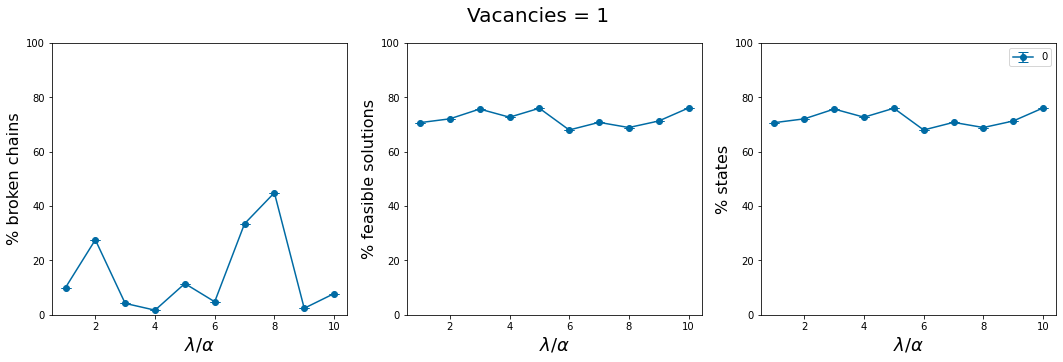

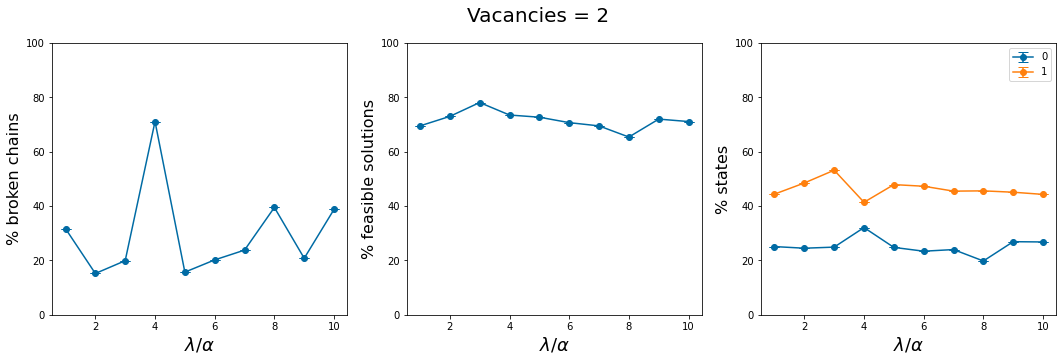

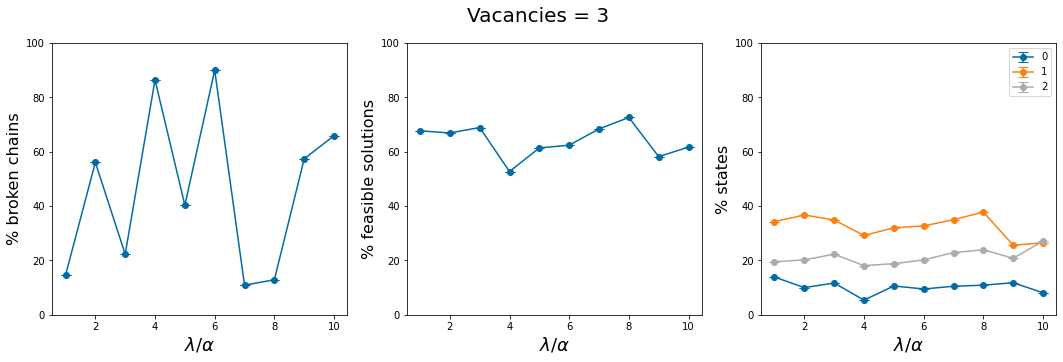

In [384]:
import os
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

directory_main = './data/paper/convergence/absolute_alpha/'

sub_directory = ['one_vacancy/','two_vacancy/','three_vacancy/']
num_reads = 1000

x = range(1,11)

#to make sure the lowest chain strength return results
#unique_energies = [[-24.0],[-22.0,-21.0],[-20.0,-19.0,-18.0]]


for i,vac in enumerate([1,2,3]):    
    directory = os.path.join(directory_main,sub_directory[i])
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    
    ratio_broken_chains = []
    ratio_broken_chains_std = []    
    ratio_feasible = []
    ratio_feasible_std = []    
    energy_distribution = []
    energy_distribution_std = []
    
    for ratio in range(1,11):
        ratio_broken_chains_tmp = []
        ratio_feasible_tmp = []
        energy_distribution_tmp = []
        
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            if os.path.isfile(f) and f.endswith(".json") and '_w1%s_'%ratio in f:
                df, param = load_json(f,return_param = True, return_qubo = False)
                ratio_broken_chains_tmp.append(find_ratio_broken_chains(df)*100)
                ratio_feasible_tmp.append(find_ratio_feasible(df,vac)*100)
                energy_distribution_tmp.append((find_energy_distribution(df,only_feasible=True,vacancies=vac)[1]))
        
        ratio_broken_chains.append(np.average(ratio_broken_chains_tmp))
        ratio_broken_chains_std.append(np.std(ratio_broken_chains_tmp))
        
        ratio_feasible.append(np.average(ratio_feasible_tmp))
        ratio_feasible_std.append(np.std(ratio_feasible_tmp))
        #print(ratio,energy_distribution_tmp)
        energy_distribution_tmp = np.array(energy_distribution_tmp)/num_reads*100       
        energy_distribution.append(np.average(energy_distribution_tmp,axis=0).tolist())
        energy_distribution_std.append(np.std(energy_distribution_tmp,axis=0).tolist())
        
    axs[0].errorbar(x, ratio_broken_chains, yerr = np.array(ratio_broken_chains_std)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, ratio_feasible, yerr = np.array(ratio_feasible_std)/2,fmt='-o',capsize=5)
    labels = [str(x) for x in range(len(energy_distribution[0]))]
    energy_distribution = np.array(energy_distribution)
    energy_distribution_std = np.array(energy_distribution_std)
    for j in range(len(energy_distribution[0])):
        axs[2].errorbar(x, energy_distribution[:,j], yerr = np.array(energy_distribution_std[:,j])/2,
                        label=labels[j], fmt='-o',capsize=5)
    
    axs[0].set_ylabel('% broken chains', fontsize=16)
    axs[1].set_ylabel('% feasible solutions', fontsize=16)
    axs[2].set_ylabel('% states', fontsize=16)
    
    axs[2].legend()
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 100])
    plt.show()
    fig.savefig('./data/images/alpha_lamdba_graphs_%s.png'%str(vac),dpi=200)

# Adjacency matrix

In [142]:
A = build_adjacency_matrix(structure)
A_pd = pd.DataFrame(A)
#dfi.export(A_pd,'./data/images/adjacency_matrix.jpg')

### THE FUNCTION

In [5]:
def find_symmetry_equivalent_structures(dataframe, structure, vacancies=None):
    #New descriptor-based version

    import copy 

    df = dataframe

    if vacancies is not None and type(vacancies) is int:
        num_atoms = sum([x.isdigit() for x in df.columns]) 
        all_config = df.iloc[:,0:num_atoms].to_numpy()
        sum_vector = np.sum(all_config,axis=1)
        feasible_config = np.where(np.round(sum_vector,5) == np.round((num_atoms - vacancies),5))[0]
        df = df.iloc[feasible_config,:]
    
    num_sites = structure.num_sites
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    multiplicity = df['num_occurrences'].to_numpy()
    chain_break = df['chain_break_fraction'].to_numpy()
    energies = df['energy'].to_numpy()
    
    #Replace the C atom with an H atom where the vacancies are
    all_structures = []
    for config in configurations:
        structure_2 = copy.deepcopy(structure)
        for j in np.where(config == 0)[0]:
            structure_2.replace(j,1)
        all_structures.append(structure_2)
    
    #Build the descriptor
    descriptor = build_descriptor(all_structures)

    descriptor_unique, descriptor_first, descriptor_count = \
    np.unique(descriptor, axis=0,return_counts=True, return_index=True)
    group_structures = []
    for desc in descriptor_unique:
        structure_desc = []
        for i,d in enumerate(descriptor):
            if np.all(np.array(desc) == np.array(d)):
                structure_desc.append(i)
        group_structures.append(structure_desc)
    
    unique_multiplicity = []
    unique_chain_break = []
    unique_structure_index = []
    
    for x in group_structures:
        unique_structure_index.append(x[0])
        unique_multiplicity.append(np.sum(multiplicity[x]))
        unique_chain_break.append(np.average(chain_break[x],weights=multiplicity[x]))    
    
    df = df.iloc[unique_structure_index]
    display(df)
    if len(df) == len(unique_multiplicity):
        df.loc[:,'num_occurrences'] = unique_multiplicity
        df.loc[:,'chain_break_fraction'] = unique_chain_break
        
        return df
    
    else:
        print('Some structures might be unfeasible, try using a smaller energy range (lower energy)')
        
        return None

dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1663078111.json')[0]
find_symmetry_equivalent_structures(dataframe, graphene_supercell, vacancies=1)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-24.0,16


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,chain_break_fraction,energy,num_occurrences
1,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.002801,-24.0,238


In [17]:
def write_crystal_files_vacancies(dataframe,structure,input_file,input_name,directory,
                        dimensionality=2,slurm_file_crystal=None, return_slurm = False):
    
    # dataframe: dataframe containing the structures (it is advised to only have the symmetry irreducible ones)
    # structure: pymatgen structure 
    # input_file: location of the sample input file
    # input_name: name of the input files generated
    # directory: directory where the files should be saved
    # dimensionality: dimensionality of the system
    # slurm_file_crystal: sample slurm file
    # return_slurm: whether to return the slurm file or not
    
    if slurm_file_crystal != None:
        file = open(slurm_file_crystal, 'r')
        slurm_file_crystal_data = file.readlines()
        file.close()    
    else:
        slurm_file_crystal_data = slurm_file_crystal
        
    crystal_input = Crystal_input().from_file(input_file)
    
    df = dataframe
    num_atoms = sum([x.isdigit() for x in df.columns])  
    
    for i in df.index:
        array = df.loc[i].to_numpy()[0:num_atoms]
        structure_tmp = copy.deepcopy(structure)        
        structure_tmp.remove_sites(np.where(array == 0)[0])
        vac = structure.num_sites - structure_tmp.num_sites
        structure_gui = cry_pmg2gui(structure_tmp,symmetry=False,dimensionality=dimensionality)
        name = input_name+'_%sv_%s'%(str(vac),i)
        structure_gui.write_crystal_gui(directory+'/%s.gui'%name,symm=False)
        crystal_input.write_crystal_input(directory+'/%s.d12'%name)
        
    
    if return_slurm == True:
        return slurm_file_crystal_data

# Vacancy-free structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = - \alpha A_{i,j} & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1

In [6]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v0_cF_w11_w20_l1_r1000_t0_1663068004.json')[0]
df_0v = make_df_paper(dataframe,num_vacancies=0,symmetrised=True,structure=graphene_supercell,num_runs=1)
# Uncomment to save the picture
#dfi.export(df_0v,'./data/images/df_0v.jpg',dpi=300)
df_0v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.0,-27.0,100.0


In [20]:
# Write the 
structure=graphene_supercell
slurm_file_crystal = './data/crystal/slurm_file_crystal.slurm'
input_file = './data/crystal/graphene.d12'
input_name = 'graphene'
directory = './data/paper/crystal/'

write_crystal_files_vacancies(df_0v,structure,input_file,input_name,directory,
                        dimensionality=2,slurm_file_crystal=None, return_slurm = False)

# One-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2 and $N_{C}$ = 17

### All structures

In [22]:
#dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1663924860.json')[0]
df_1v = make_df_paper(dataframe,num_vacancies=1,symmetrised=False,only_feasible=False,structure=graphene_supercell,num_runs=1)
sort = np.where(df_1v.iloc[:,0:18].to_numpy() == 0)[1]
df_1v = df_1v.iloc[sort,:]
# Uncomment to save the picture
#dfi.export(df_1v,'./data/images/df_1v_symm.jpg',dpi=300)
df_1v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.90,-24.0,4.1
p,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.26,-24.0,2.1
o,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.87,-24.0,2.9
n,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.96,-24.0,5.2
m,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.29,-24.0,3.8
l,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.51,-24.0,2.2
k,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,0.30,-24.0,3.7
j,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1.15,-24.0,2.9
i,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,0.00,-24.0,2.2
h,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1.05,-24.0,10.1


### Symmetry-inequivalent structures only

In [23]:
#dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1666191205.json')[0]
dataframe = load_json('./data/paper/graphene_C18_bqm_v1_cF_w11_w20_l2_r1000_t0_1663924860.json')[0]
df_1v = make_df_paper(dataframe,num_vacancies=1,symmetrised=True,only_feasible=False,structure=graphene_supercell,num_runs=1)
sort = np.where(df_1v.iloc[:,0:18].to_numpy() == 0)[1]
df_1v = df_1v.iloc[sort,:]
# Uncomment to save the picture
#dfi.export(df_1v,'./data/images/df_1v_symm.jpg',dpi=300)
df_1v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.063,-24.0,73.7


# Two-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2 and $N_{C}$ = 16

### All structures

In [26]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v2_cF_w11_w20_l2_r1000_t0_1663860866.json')[0]
df_2v = make_df_paper(dataframe,num_vacancies=2,symmetrised=False,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_2v,'./data/images/df_2v_symm.jpg',dpi=300)
df_2v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
22,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.56,-22.0,1.0
43,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1.39,-22.0,0.4
110,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,0.56,-22.0,1.0
48,1,1,1,0,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.00,-22.0,0.8
37,1,1,0,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.37,-22.0,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,0.00,-21.0,0.3
42,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,2.78,-21.0,0.4
41,1,1,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,0.00,-21.0,0.3
58,1,1,1,1,0,1,0,1,1,1,...,1,1,1,1,1,1,1,0.00,-21.0,0.2


### Symmetry-inequivalent structures only

In [27]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v2_cF_w11_w20_l2_r1000_t0_1663860866.json')[0]
df_2v = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_2v,'./data/images/df_2v_symm.jpg',dpi=300)
df_2v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.884,-22.0,24.5
b,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.561,-21.0,20.8
c,0,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,0.688,-21.0,12.1
d,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1.054,-21.0,11.6
e,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0.383,-21.0,5.8


# Three-vacancy structure
QUBO model:
$$
    \bf{Q}
    \begin{cases}
        Q_{i,j} = \lambda\left(1-2N_{C}\right) & \text{for } i=j \\
        Q_{i,j} = \left(2\lambda - \alpha A_{i,j}\right) & \text{for } j>i \\
        Q_{i,j} = 0 & \text{for } j<i
    \end{cases}
$$
where $\alpha$ = 1, $\lambda$ = 2 and $N_{C}$ = 15

### All structures

In [29]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df_3v = make_df_paper(dataframe,num_vacancies=3,symmetrised=False,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_3v,'./data/images/df_3v_symm.jpg',dpi=300)
df_3v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
178,1,1,1,0,1,1,0,1,1,1,...,1,0,1,1,1,1,1,0.00,-20.0,0.1
117,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,0,1,0.00,-20.0,0.3
113,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,0.00,-20.0,0.2
234,1,1,1,1,1,0,0,1,1,1,...,1,0,1,1,1,1,1,0.00,-20.0,0.2
111,1,0,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.00,-20.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1,1,0,1,1,1,1,1,1,1,...,1,1,1,0,1,0,1,0.00,-18.0,0.1
173,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,0,1,0.00,-18.0,0.1
174,1,1,1,0,0,1,1,1,1,1,...,1,1,1,1,1,1,0,2.78,-18.0,0.2
136,1,1,0,1,1,0,0,1,1,1,...,1,1,1,1,1,1,1,0.00,-18.0,0.1


### Symmetry-inequivalent structures only

In [31]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df_3v = make_df_paper(dataframe,num_vacancies=3,symmetrised=True,structure=graphene_supercell,num_runs=1)
#Uncomment to save the picture
#dfi.export(df_3v,'./data/images/df_3v_symm.jpg',dpi=300)
df_3v

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0.681,-20.0,10.6
b,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1.651,-19.0,10.1
c,0,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.947,-19.0,8.8
d,0,1,1,1,1,0,1,1,1,0,...,1,1,1,1,1,1,1,2.726,-19.0,5.3
e,0,1,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,0.811,-19.0,4.8
f,0,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.390,-18.0,0.8
g,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1.853,-18.0,0.6
h,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.527,-18.0,1.1
i,0,0,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,2.829,-18.0,5.7
j,1,0,0,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,2.911,-18.0,2.1


# Add coordination

# DF 2 vac

In [192]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v2_cT_w11_w20.05_l2_r1000_t0_1667490895.json')[0]
df_2v_coord = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
dfi.export(df_2v_coord,'./data/images/df_3v_coord.jpg')
df_2v_coord

objc[66468]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x219209b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/109.0.5414.119/Libraries/libGLESv2.dylib (0x10a393b30). One of the two will be used. Which one is undefined.
[0210/103551.976238:INFO:headless_shell.cc(223)] 32536 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmp9d70n1fi/temp.png


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurrence
a,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,0.598,-19.90,19.5
b,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,3.425,-18.90,8.6
c,0,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,0.624,-18.90,9.8
d,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,0.768,-18.90,9.4
e,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.157,-18.85,27.3


In [62]:
structure=graphene_supercell
slurm = write_crystal_files(df_2v_coord,structure,dimensionality=2,slurm_file_crystal=slurm,return_slurm=True)

# DF 3 vac

In [32]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v3_cT_w11_w20.05_l2_r1000_t0_1666361376.json')[0]
df_3v_coord = make_df_paper(dataframe,num_vacancies=3,symmetrised=True,structure=graphene_supercell,num_runs=1)
dfi.export(df_3v_coord,'./data/images/df_3v_coord.jpg')
df_3v_coord

objc[72104]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x24a625b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x109debc28). One of the two will be used. Which one is undefined.
53111 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpp_2jbr15/temp.png
objc[72119]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x24a625b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x108227c28). One of the two will be used. Which one is undefined.
53111 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmp647w08ny

objc[72299]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x24a625b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x10995bc28). One of the two will be used. Which one is undefined.
53111 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpfk_muxxj/temp.png
objc[72310]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x24a625b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x109bf7c28). One of the two will be used. Which one is undefined.
53111 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpy5el5hc7

objc[72490]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x24a625b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x105d2fc28). One of the two will be used. Which one is undefined.
53111 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmp0gnjk864/temp.png
objc[72501]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x24a625b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x1095ebc28). One of the two will be used. Which one is undefined.
53111 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmpxpk_uz5g

SyntaxError: not a PNG file (<string>)

In [63]:
structure=graphene_supercell
slurm = write_crystal_files(df_3v_coord,structure,dimensionality=2,slurm_file_crystal=slurm,return_slurm=True)

## Symmetry of solution

## 1 vac

In [196]:
directory = './data/paper/convergence/solution_symmetry/one_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
dataframe = pd.concat(dfs)

df_1v_solsymm = make_df_paper(dataframe,num_vacancies=1,symmetrised=False,only_feasible=True,structure=graphene_supercell)    


sort = np.where(df_1v_solsymm.iloc[:,0:18].to_numpy() == 0)[1]
df_1v_solsymm = df_1v_solsymm.iloc[sort,:]

dfi.export(df_1v_solsymm,'./data/images/df_1v_solsymm.jpg')

objc[66501]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x219209b50) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/109.0.5414.119/Libraries/libGLESv2.dylib (0x109bffb30). One of the two will be used. Which one is undefined.
[0210/103626.647490:INFO:headless_shell.cc(223)] 77545 bytes written to file /var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/tmp4lr_eikf/temp.png


In [149]:
directory = './data/paper/convergence/solution_symmetry/one_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
std = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
    dataframe = pd.concat(dfs)

    df_1v_solsymm = make_df_paper(dataframe,num_vacancies=1,symmetrised=False,only_feasible=True,structure=graphene_supercell)    
    std.append(np.std(df_1v_solsymm['% occurrence']))




In [239]:
np.math.factorial(27)/(np.math.factorial(18)*np.math.factorial(9))

4686825.0

In [229]:
fit = np.polyfit(x, std, 1, rcond=None, full=False, w=None, cov=False)

In [227]:
xx = []
for i in range(100):
    #xx.append((fit[2]+fit[1]*i+fit[0]*i**2))
    xx.append((fit[3]+fit[2]*i+fit[1]*i**2+fit[0]*(i**3)))
    #print((fit[3]+fit[2]*i+fit[1]*i**3+fit[0]*i**3)-std[i])

In [234]:
yy = []
for i in range(40,100):
    #xx.append((fit[2]+fit[1]*i+fit[0]*i**2))
    yy.append((fit[1]+fit[0]*i))
    #print((fit[3]+fit[2]*i+fit[1]*i**3+fit[0]*i**3)-std[i])

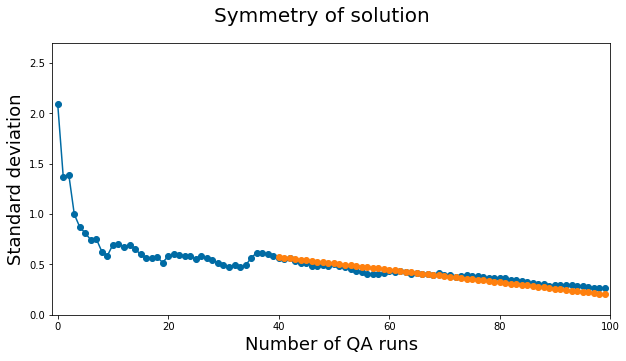

In [235]:
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')
fig, axs = plt.subplots(1,1,figsize=(10, 5), sharey=False)
fig.suptitle('Symmetry of solution', fontsize=20)
axs.plot(np.arange(100),std,'o-')
axs.plot(np.arange(40,100),yy,'o-')
axs.set_xlim([-1,100])
axs.set_ylim([0, 2.7])
axs.set_ylabel('Standard deviation', fontsize=18)


axs.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
axs.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
axs.set_xlabel("Number of QA runs", fontsize=18)
fig.savefig('./data/images/symmetry_solutions.png',dpi=200)

## 2 vac

In [123]:
directory = './data/paper/convergence/solution_symmetry/two_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
dataframe = pd.concat(dfs)

df_2v_solsymm = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,only_feasible=True,structure=graphene_supercell)    

In [124]:
df_2v_solsymm

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
a,0,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1.661,-22.0,31.283134
b,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1.915,-21.0,29.100521
c,0,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,2.362,-21.0,15.513091
d,0,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1.908,-21.0,14.594563
e,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1.848,-21.0,9.508691


In [111]:
df = df_2v_solsymm
unique_structures = df2structure(graphene_supercell,df)
unique_descriptor = build_descriptor(unique_structures)
all_structures = generate_all_structures(graphene_supercell,2)
find_multiplicity(all_structures,descriptor_unique=unique_descriptor)

array([27, 54, 27, 27, 18])

## 3 vac

In [126]:
directory = './data/paper/convergence/solution_symmetry/three_vacancy/'

num_reads = 1000
num_runs = len(os.listdir(directory))
dfs = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f) and f.endswith(".json"):
        dataframe = load_json(f)[0]
        '''df = make_df_paper(dataframe,num_vacancies=2,symmetrised=True,structure=graphene_supercell,num_runs=1)
        display(df)'''
        dfs.append(load_json(f,return_param = False, return_qubo = False))
dataframe = pd.concat(dfs)

df_3v_solsymm = make_df_paper(dataframe,num_vacancies=3,symmetrised=True,only_feasible=True,structure=graphene_supercell)    



In [127]:
df_3v_solsymm

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,% broken chains,Energy,% occurence
a,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,2.412,-20.0,18.083523
b,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,2.420,-19.0,16.790723
c,0,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,2.508,-19.0,16.845569
d,0,1,1,1,1,0,1,1,1,0,...,1,1,1,1,1,1,1,2.109,-19.0,8.018491
e,0,1,1,1,1,0,1,1,1,1,...,0,1,1,1,1,1,1,2.549,-19.0,8.175194
f,0,0,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,3.383,-18.0,1.363316
g,0,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,2.148,-18.0,1.236386
h,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,3.840,-18.0,1.385254
i,0,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,3.906,-18.0,8.543446
j,0,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,3.036,-18.0,4.017864


In [128]:
df = df_3v_solsymm
unique_structures = df2structure(graphene_supercell,df)
unique_descriptor = build_descriptor(unique_structures)
all_structures = generate_all_structures(graphene_supercell,num_vacancies=3)
find_multiplicity(all_structures,descriptor_unique=unique_descriptor)

array([ 54, 108, 108,  54,  54,  18,  18,  18, 108,  54, 108,  54,  54,
         6])

### Boltzman analysis

In [152]:
#STRUCTURES RETURNED BY THE ANNEALING
unique_config = df_2v.iloc[:,0:18].to_numpy()
unique_structures = []

for config in unique_config:
    structure = copy.deepcopy(graphene_supercell)
    for j in np.where(config==0)[0]:
        structure.replace(j,1)
    unique_structures.append(structure)    

In [345]:
#ALL STRUCTURES
def generate_all_structures(structure_inp,num_vacancies):
    
    import itertools
    
    num_sites = structure_inp.num_sites
    
    num_atoms = num_sites - num_vacancies
    
    X = np.array(list(itertools.product([0, 1], repeat=num_sites)))
    indices = np.where(np.sum(X,axis=1)==num_atoms)[0]
    X_final = X[indices]

    all_structures = []
    for config in X_final:
        structure = copy.deepcopy(structure_inp)
        for j in np.where(config==0)[0]:
            structure.replace(j,1)
        all_structures.append(structure)    
    return all_structures

In [9]:
#THIS GIVES THE WRONG SYMMETRY ANALYSIS
from pymatgen.analysis.structure_matcher import StructureMatcher

unique_structures_label = []

#Find to which class the structures belong to
for structure in all_structures:
    for i in range(len(unique_structures)):
        #print(unique_structures[i][0].composition.reduced_formula,structure.composition.reduced_formula)
        if StructureMatcher().fit(structure,unique_structures[i]) == True:
            unique_structures_label.append(i)
            break


## Distance - based analysis

In [48]:
distances = []
for structure in all_structures:
    vac_sites = np.where(np.array(structure.atomic_numbers)==1)[0]
    dist = structure.sites[vac_sites[0]].distance(structure.sites[vac_sites[1]])
    #distances.append(np.round(structure.distance_matrix[vac_sites[0]][vac_sites[1]],5))
    distances.append(np.round(dist,5))
distances = np.array(distances)

## Descriptor - based analysis

In [72]:
def cart2sph_array(array):
    sph_coordinates = []
    for line in array:
        x = line[0]
        y = line[1]
        z = line[2]
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        el = np.arctan2(z, hxy)
        az = np.arctan2(y, x)
        if np.around(az,6) ==  np.around(2*np.pi,6) \
        or np.around(az,6) ==  -np.around(2*np.pi,6):
            az = 0.
        if np.around(az,6) < 0.:
            az = np.round(2*np.pi+az,6)
        sph_coordinates.append([round(r,6), round(el,6), round(az,6) ])   
    return sph_coordinates

In [264]:
#BUILD THE DESCRIPTOR
'''shells = np.unique(np.round(all_structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
structures = copy.deepcopy(all_structures)
structures = copy.deepcopy(unique_structures)'''
def build_descriptor(structures,max_shell=3):
    shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6),return_counts=True)[0].tolist()
    neighbours_spatial_dist = []
    neighbours_spatial_dist_all = []
    
    for k,structure in enumerate(structures): 
        time0 = time.time()
        neighbours_spatial_dist = []

        for j in range(structure.num_sites):
            centered_sph_coords = []
            neighbours_spatial_dist_atom = []

            for m,n in enumerate(range(max_shell+1)):
                centered_sph_coords = []

                neighbours = structure.get_neighbors_in_shell(structure.sites[j].coords,shells[n],0.2)
                new_cart_coords = [x.coords.tolist() for x in neighbours]
                atom_numbers = [x.specie.number for x in neighbours]
                
                #SORT DESCRIPTOR
                neighbours_spatial_dist_atom.extend(np.sort(np.array(atom_numbers)))

            neighbours_spatial_dist.append(neighbours_spatial_dist_atom)

        neighbours_spatial_dist_all.append(neighbours_spatial_dist)     

    #ALL AT ONCE
    neighbours_spatial_dist_all = np.array(neighbours_spatial_dist_all)

    neighbours_spatial_dist_all_sorted = []
    sorting = []

    for k,structure in enumerate(range(neighbours_spatial_dist_all.shape[0])):
        sorted_atoms = []
        for i in range(neighbours_spatial_dist_all.shape[1]):
            sorted_atoms.append(int(''.join([str(x) for x in neighbours_spatial_dist_all[k][i]])))
        sorting.append(np.argsort(np.array(sorted_atoms))) 
        neighbours_spatial_dist_all_sorted.append((np.array(neighbours_spatial_dist_all)[k][np.argsort(np.array(sorted_atoms))]).tolist())
    neighbours_spatial_dist_all_sorted = np.array(neighbours_spatial_dist_all_sorted)   

    neighbours_spatial_dist_all_sorted_sliced = neighbours_spatial_dist_all_sorted[:,:,1:]

    n_structures = neighbours_spatial_dist_all_sorted_sliced.shape[0]
    vector_len = neighbours_spatial_dist_all_sorted_sliced.shape[1] * neighbours_spatial_dist_all_sorted_sliced.shape[2]
    neighbours_spatial_dist_all_sorted_sliced_flat = \
    np.reshape(neighbours_spatial_dist_all_sorted_sliced, [n_structures,vector_len])

    neighbours_spatial_dist_all_sorted_sliced_reduced = \
    neighbours_spatial_dist_all_sorted_sliced[neighbours_spatial_dist_all_sorted_sliced != 8]

    vector_len = int(neighbours_spatial_dist_all_sorted_sliced_reduced.shape[0]/n_structures)

    neighbours_spatial_dist_all_sorted_sliced_reduced = \
    np.reshape(neighbours_spatial_dist_all_sorted_sliced_reduced,[n_structures,vector_len])

    descriptor = np.array(neighbours_spatial_dist_all_sorted_sliced_reduced)
    
    return descriptor

In [249]:
def find_multiplicity(all_structures,descriptor_unique=[None]):
    
    descriptor = build_descriptor(all_structures)
    
    if len(descriptor_unique) > 0:
        descriptor_unique, descriptor_first, descriptor_count = \
                                    np.unique(descriptor, axis=0,return_counts=True, return_index=True)
    group_structures = []
    for desc in descriptor_unique:
        structure_desc = []
        for i,d in enumerate(descriptor):
            if np.all(np.array(desc) == np.array(d)):
                structure_desc.append(i)
        group_structures.append(len(structure_desc))
        
    group_structures = np.array(group_structures)
    
    return group_structures

In [241]:
def df2structure(structure,df):
    
    num_sites = structure.num_sites
    configurations = df.iloc[:,0:num_sites].to_numpy()
    
    #Replace the C atom with an H atom where the vacancies are
    all_structures = []
    for config in configurations:
        structure_2 = copy.deepcopy(structure)
        for j in np.where(config == 0)[0]:
            structure_2.replace(j,1)
        all_structures.append(structure_2)
    
    return all_structures

In [350]:
dataframe = load_json('./data/paper/graphene_C18_bqm_v3_cF_w11_w20_l2_r1000_t0_1663870143.json')[0]
df_3v = find_symmetry_equivalent_structures(dataframe, graphene_supercell, vacancies=3)
#find_multiplicity(all_structures_3,build_descriptor(df2structure(graphene_supercell,dataframe)))

In [351]:
unique_structures = df2structure(graphene_supercell,df_3v)
unique_descriptor = build_descriptor(unique_structures)

In [352]:
find_multiplicity(all_structures_3,descriptor_unique=unique_descriptor)

array([ 54, 108, 108,  54,  54,  18,  18,  18, 108,  54, 108,  54,  54,
         6])

In [354]:
descriptor = build_descriptor(all_structures_3)

In [357]:
np.unique(descriptor, axis=0,return_counts=True, return_index=True)

(array([[1, 1, 6, ..., 6, 6, 6],
        [1, 6, 6, ..., 6, 6, 6],
        [1, 6, 6, ..., 6, 6, 6],
        ...,
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6],
        [6, 6, 6, ..., 6, 6, 6]]),
 array([ 8, 13,  7, 61, 63,  2,  4,  0,  1, 15, 11, 10, 65, 59]),
 array([ 54, 108, 108,  54,  54,  18,  18,  18, 108,  54, 108,  54,  54,
          6]))

In [163]:
anneal_unique_descriptors = build_descriptor(unique_structures)
descriptor = build_descriptor(all_structures)

In [154]:
neighbours_spatial_dist_all

[[[1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6],
  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6],
  [1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6],
  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 1, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6]],
 [[1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6],
  [6, 6, 6

In [157]:
#ASSIGN STRUCTURES TO GROUP

descriptor_unique, descriptor_first, descriptor_count = \
np.unique(descriptor, axis=0,return_counts=True, return_index=True)

group_structures = []
for desc in descriptor_unique:
    structure_desc = []
    for i,d in enumerate(descriptor):
        if np.all(np.array(desc) == np.array(d)):
            structure_desc.append(i)
    group_structures.append(structure_desc)
#group_structures = np.array(group_structures)

In [165]:
#ASSIGN STRUCTURES TO UNIQUE STRUCTURES RETURNED BY THE ANNEAL

descriptor_unique, descriptor_first, descriptor_count = \
np.unique(descriptor, axis=0,return_counts=True, return_index=True)

group_structures = []
for desc in anneal_unique_descriptors:
    structure_desc = []
    for i,d in enumerate(descriptor):
        if np.all(np.array(desc) == np.array(d)):
            structure_desc.append(i)
    group_structures.append(structure_desc)
#group_structures = np.array(group_structures)

In [167]:
for i in range(len(group_structures)):
    print(len(group_structures[i]))

27
54
18
27
27


In [179]:
np.where(np.array(all_structures[group_structures[4][0]].atomic_numbers)==1)

(array([ 0, 13]),)

In [173]:
view(AseAtomsAdaptor().get_atoms(graphene_supercell))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [149]:
#TEST ALL STRUCTURES IN A GROUP HAVE THE SAME VAC-VAC DISTANCE
for i in range(len(group_structures)):
    print(i)
    for j in group_structures[i]:
        indices = np.where(np.array(all_structures[j].atomic_numbers) == 1)[0]
        print(j,all_structures[j].distance_matrix[indices[0]][indices[1]])

0
8 1.4247411973035642
9 1.4247411973035642
14 1.4247411973035626
25 1.424741197303564
26 1.4247411973035646
31 1.4247411973035642
39 1.4247411973035637
41 1.4247411973035646
47 1.424741197303562
53 1.4247411973035637
56 1.4247411973035642
57 1.4247411973035644
67 1.4247411973035642
70 1.4247411973035642
71 1.4247411973035633
80 1.4247411973035644
81 1.4247411973035633
83 1.4247411973035646
92 1.4247411973035637
95 1.4247411973035646
96 1.4247411973035642
103 1.4247411973035646
106 1.4247411973035633
107 1.4247411973035646
113 1.424741197303563
114 1.4247411973035644
116 1.4247411973035646
1
0 2.467724141366287
1 2.4677241413662863
2 2.467724141366287
3 2.467724141366287
5 2.4677241413662863
7 2.467724141366288
17 2.467724141366288
19 2.467724141366287
20 2.4677241413662876
21 2.4677241413662876
22 2.4677241413662863
33 2.467724141366287
35 2.467724141366289
37 2.4677241413662863
38 2.4677241413662867
48 2.4677241413662876
49 2.4677241413662867
50 2.4677241413662876
51 2.46772414136628

In [6]:
def make_df(directory):

    import os

    dataframes = []

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and f.endswith(".json") and 'bqm' in f:
            #print(f)
            df, param = load_json(f,return_param = True, return_qubo = False)        
            param = param.transpose()
            n_vac = param['num_vacancies'].values[0]
            n_atoms = param['N atoms'].values[0]
            param['broken_chains'] = find_ratio_broken_chains(df)   
            param['ratio_feasible'] = find_ratio_feasible(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['ratio_gs'] = find_ratio_ground_state(df,param['num_vacancies'].values[0], remove_broken_chains=False)
            param['energy_distribution_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[0])
            param['multiplicity_all'] = ', '.join(str(x) for x in find_energy_distribution(df)[1])        
            param['energy_distribution'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[0])
            #param['num_broken_bonds'] = ', '.join(str(x) for x in find_num_broken_bonds(dataframe, remove_broken_chains = True, only_feasible = True, vacancies = param['num_vacancies'].values[0]))
            param['multiplicity'] = ', '.join(str(x) for x in find_energy_distribution(df, only_feasible=True, vacancies=param['num_vacancies'].values[0])[1])
            param['ratio l/w'] =  param['lagrange'] / param['weight_1'] 
            param['vacancies'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[0])
            param['vacancies mult'] = ', '.join(str(x) for x in find_vacancy_distribution(df)[1])
            
            if 'chain_strength' not in param:
                param['chain_strength'] = -1
            #print(param['chain_strength'])
            if param['chain_strength'].all() == None:
                param['chain_strength'] = -1
            dataframes.append(param)

    df_results = pd.concat(dataframes)
    
    return df_results

## $\alpha$ , $\gamma$ ratio

### weight_1 = 1

In [483]:
make_df('./data/paper/convergence/alpha_gamma/')

,date_time,time_stamp,structure,N atoms,model,use_coord,num_vacancies,weight_1,weight_2,lagrange,...,broken_chains,ratio_feasible,ratio_gs,energy_distribution_all,multiplicity_all,energy_distribution,multiplicity,ratio l/w,vacancies,vacancies mult
Values,"10/31/2022, 15:21:24",1667229684,C18,18,bqm,False,2,1,0,7,...,0.591,0.582,0.092,"-22.0, -21.0, -17.0, -13.0, -12.0, -11.0, 10.0...","92, 490, 40, 25, 106, 212, 1, 2, 5, 27","-22.0, -21.0","92, 490",7.0,"1, 2, 3, 4","40, 582, 343, 35"
Values,"10/31/2022, 15:05:22",1667228722,C18,18,bqm,False,3,1,0,1,...,0.183,0.343,0.115,"-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15.0","302, 455, 187, 42, 4, 7, 3","-20.0, -19.0, -18.0","115, 187, 41",1.0,"0, 1, 2, 3, 4","1, 44, 598, 343, 14"
Values,"10/31/2022, 15:25:22",1667229922,C18,18,bqm,False,3,1,0,1,...,0.875,0.201,0.031,"-21.0, -20.0, -19.0, -18.0, -15.0, -14.0","202, 624, 75, 96, 1, 2","-20.0, -19.0, -18.0","31, 75, 95",1.0,"0, 1, 2, 3, 4","1, 143, 652, 201, 3"
Values,"10/31/2022, 15:16:15",1667229375,C18,18,bqm,False,1,1,0,2,...,0.403,0.699,0.699,"-25.0, -24.0, -20.0, -19.0, -11.0, -10.0","85, 699, 54, 159, 1, 2",-24.0,699,2.0,"0, 1, 2, 3","85, 699, 213, 3"
Values,"10/31/2022, 14:54:22",1667228062,C18,18,bqm,False,2,1,0,5,...,0.261,0.660,0.130,"-22.0, -21.0, -19.0, -15.0, -14.0, -13.0, 3.0,...","130, 530, 39, 29, 130, 130, 4, 4, 4","-22.0, -21.0","130, 530",5.0,"1, 2, 3, 4","39, 660, 289, 12"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Values,"10/31/2022, 15:16:05",1667229365,C18,18,bqm,False,2,1,0,1,...,0.160,0.359,0.187,"-23.0, -22.0, -21.0, -19.0, -18.0, -17.0","619, 187, 172, 7, 12, 3","-22.0, -21.0","187, 172",1.0,"0, 1, 2, 3","33, 586, 359, 22"
Values,"10/31/2022, 15:27:07",1667230027,C18,18,bqm,False,3,1,0,6,...,0.214,0.629,0.072,"-20.0, -19.0, -18.0, -16.0, -15.0, -12.0, -11....","72, 258, 299, 9, 35, 17, 95, 128, 74, 3, 1, 4,...","-20.0, -19.0, -18.0","72, 258, 299",6.0,"2, 3, 4, 5","44, 629, 314, 13"
Values,"10/31/2022, 15:16:10",1667229370,C18,18,bqm,False,3,1,0,1,...,0.512,0.297,0.110,"-21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15.0","307, 487, 145, 44, 4, 6, 7","-20.0, -19.0, -18.0","110, 145, 42",1.0,"0, 1, 2, 3, 4","2, 79, 605, 297, 17"
Values,"10/31/2022, 15:15:50",1667229350,C18,18,bqm,False,2,1,0,10,...,0.681,0.580,0.147,"-22.0, -21.0, -14.0, -10.0, -9.0, -8.0, 22.0, ...","147, 433, 37, 14, 202, 140, 1, 10, 11, 5","-22.0, -21.0","147, 433",10.0,"1, 2, 3, 4","37, 580, 356, 27"


In [485]:
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/')

num_runs = 1000
num_reads = 1000

for vac in [1,2,3]:    
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1.]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()
    #y5 = df_mean['ratio_gs'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio l/w'] == k]
        
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            #v_energy = np.array([float(x)/num_runs for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            #v_mult = np.array([float(x)/num_runs for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
            
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    #for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        #axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)
    
    #axs[4].plot(x,y5,'-o')


    
    axs[0].set_ylabel('ratio broken chains', fontsize=14)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=14)
    axs[2].set_ylabel('ratio states', fontsize=14)
    #axs[3].set_ylabel('ratio vacancies', fontsize=14)
    #axs[4].set_ylabel('ratio gs', fontsize=14)
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 1])
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

    plt.show()
    fig.savefig('./data/images/alpha_gamma_graphs_%s.png'%str(vac),dpi=200)

ValueError: No objects to concatenate

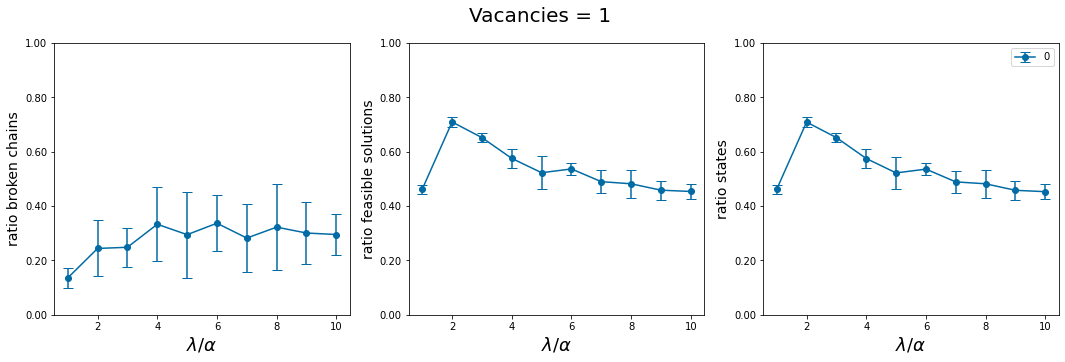

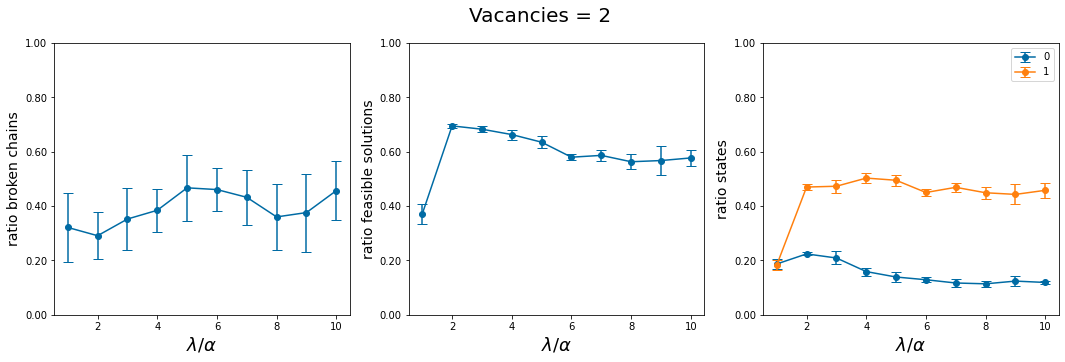

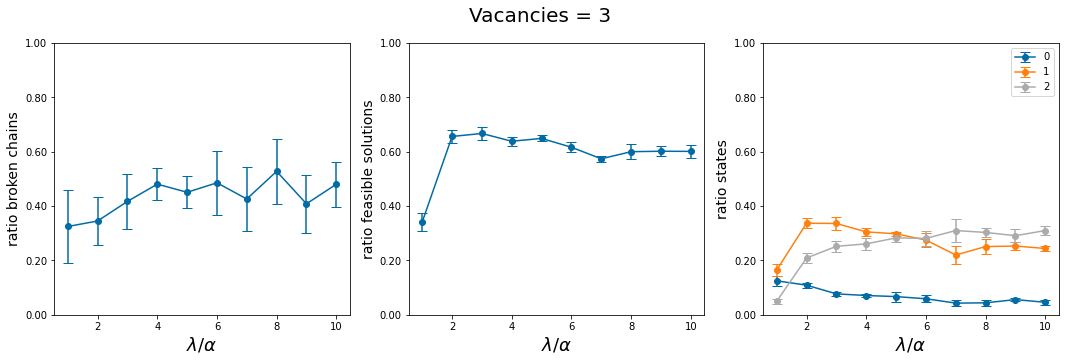

In [35]:
#SAVE
import matplotlib.pyplot as plt
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/')

num_runs = 1000
num_reads = 1000

for vac in [1,2,3]:    
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1.]
    df_mean = df_all[df_all['weight_1'] == 1.].groupby('ratio l/w').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()
    #y5 = df_mean['ratio_gs'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        
        df_tmp = df_all[df_all['ratio l/w'] == k]
        
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            #v_energy = np.array([float(x)/num_runs for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            #v_mult = np.array([float(x)/num_runs for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
            
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    error_y4 = np.array(error_y4)
    error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    #for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        #axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))

    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)
    
    #axs[4].plot(x,y5,'-o')


    
    axs[0].set_ylabel('ratio broken chains', fontsize=14)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=14)
    axs[2].set_ylabel('ratio states', fontsize=14)
    #axs[3].set_ylabel('ratio vacancies', fontsize=14)
    #axs[4].set_ylabel('ratio gs', fontsize=14)
    
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel(r'$\lambda / \alpha$', fontsize=18)
        axs[i].set_ylim([0, 1])
    #fig.set_title('All feasible',fontsize=20)

#axs[:].set_xticks(np.arange(0,25))
#ax.set_yticks(np.arange(-50,0,5))
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=16)

#fig.set_size_inches(15.5, 7.5)

    plt.show()
    fig.savefig('./data/images/alpha_gamma_graphs_%s.png'%str(vac),dpi=200)

### chain strength - uniform torque compensation

In [53]:
df_all['chain_strength'] = np.round(df_all['chain_strength'].to_numpy(dtype=float),5)

[ 1.5843   3.1686   4.75289  6.33719  7.92149  9.50579 11.09009 12.67438
 14.25868 15.84298]


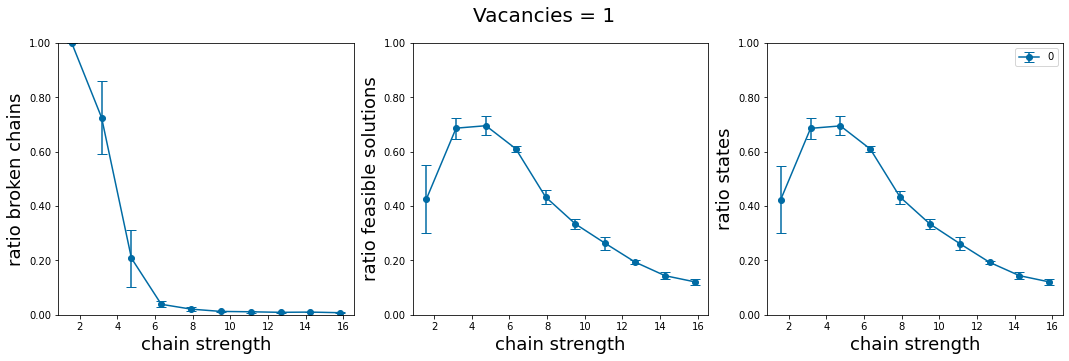

[ 1.5843   3.1686   4.75289  6.33719  7.92149  9.50579 11.09009 12.67438
 14.25868 15.84298]


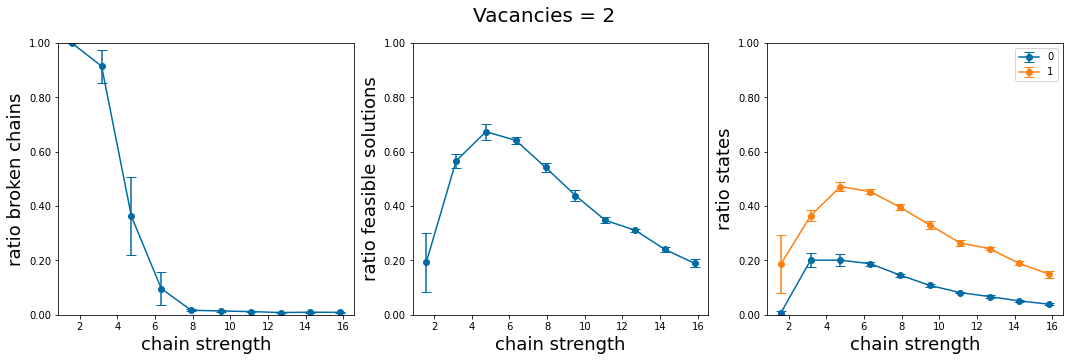

[ 1.5843   3.1686   4.75289  6.33719  7.92149  9.50579 11.09009 12.67438
 14.25868 15.84298]


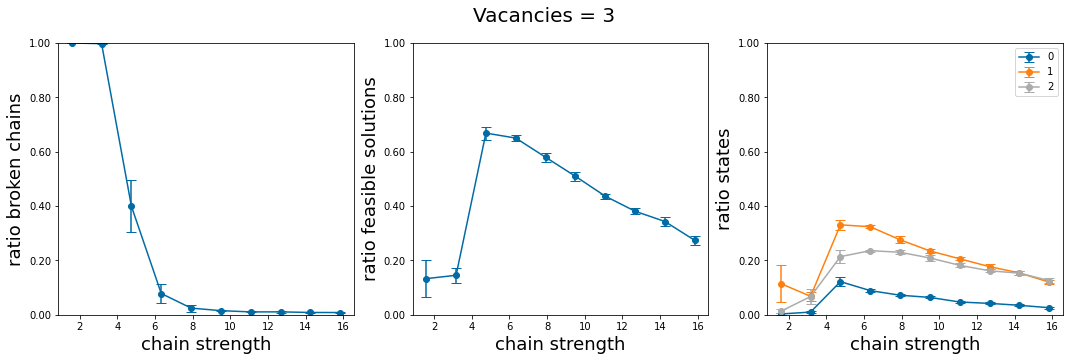

In [65]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/chain_strength/')

df_results.index = [int(x) for x in np.arange(len(df_results.index))]
np.where(df_results['energy_distribution'] == '')
df_results.drop(index=np.where(df_results['energy_distribution'] == '')[0], inplace=True)

for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_all['chain_strength'] = np.round(df_all['chain_strength'].to_numpy(dtype=float),5)
    df_mean = df_all[df_all['weight_1'] == 1].groupby('chain_strength').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['chain_strength'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            if i != '':
                energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))

        '''for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))'''
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    #y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    #y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    #error_y4 = np.array(error_y4)
    #error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    '''for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))
'''
    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('chain strength', fontsize=18)
    axs[1].set_xlabel('chain strength', fontsize=18)
    axs[2].set_xlabel('chain strength', fontsize=18)
    #axs[3].set_xlabel('chain strength', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('ratio states', fontsize=18)
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel('chain strength', fontsize=18)
        axs[i].set_ylim([0, 1])
    plt.show()
    fig.savefig('./data/images/chain_strength_graphs_%s.png'%str(vac),dpi=200)
plt.show()

# anneal time

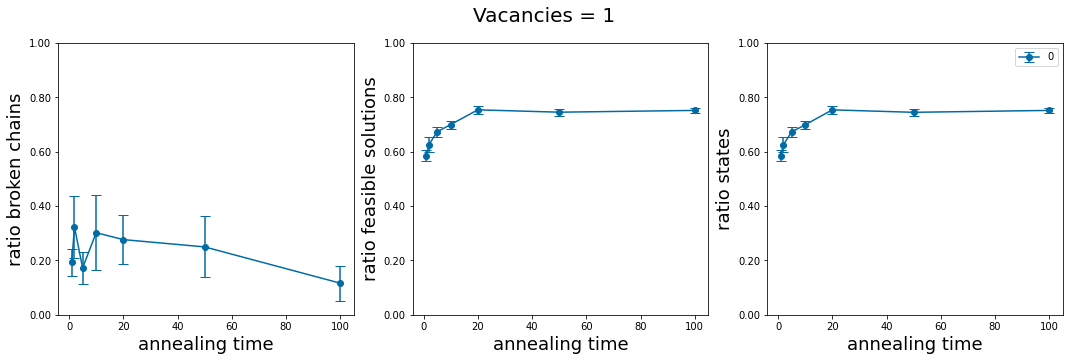

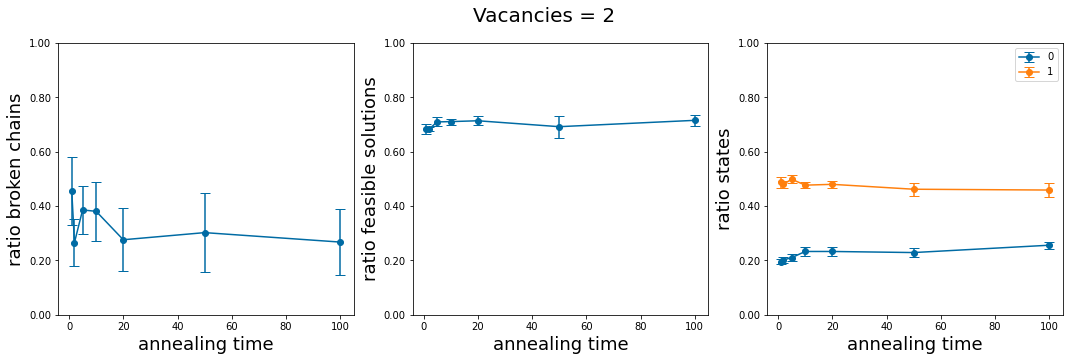

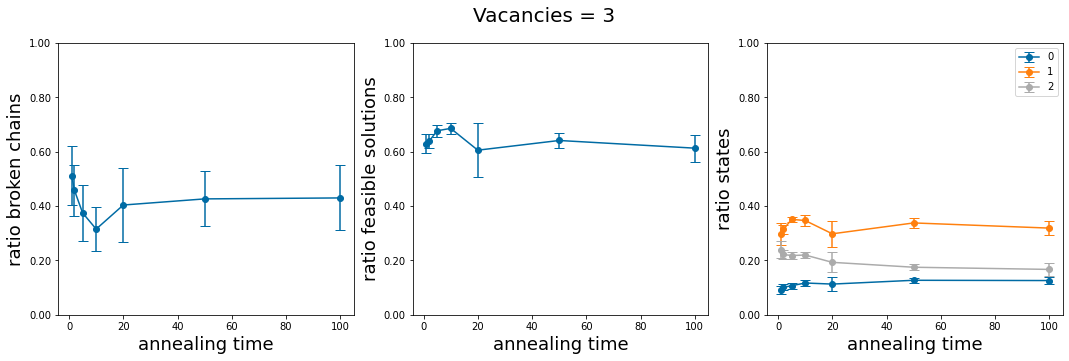

In [67]:
#FEASIBLE
import matplotlib.pyplot as plt

color = ['b','g','r','c','m','y','k','tab:orange',]
point = ['-o','^','s']

plt.style.use('tableau-colorblind10')

df_results = make_df('./data/paper/convergence/anneal_time/')

for vac in [1,2,3]:
    df_all = df_results[df_results['num_vacancies'] == vac]
    df_all = df_all[df_all['weight_1'] == 1]
    df_mean = df_all[df_all['weight_1'] == 1].groupby('qpu_anneal_time_per_sample').mean()
    fig, axs = plt.subplots(1,3,figsize=(18, 5), sharey=False)
    fig.suptitle('Vacancies = %s'%vac, fontsize=20)
    
    x = df_mean.index.values

    y1 = df_mean['broken_chains'].to_numpy()
    y2 = df_mean['ratio_feasible'].to_numpy()

    y3 = []
    y4 = []
    error_y3 = []
    error_y4 = []
    error_bc = []
    error_rf = []
    for n,k in enumerate(x):
        df_tmp = df_all[df_all['qpu_anneal_time_per_sample'] == k]
        energies = []
        for i in df_all['energy_distribution']:
            energies.extend([float(x) for x in i.split(',')])         
        all_energies = np.unique(np.array(energies))
        labels = [str(x) for x in range(len(all_energies))]
        dist_average = np.array([0]*len(all_energies))
        all_dist = []
        
        vacancies = []
        for i in df_all['vacancies']:
            vacancies.extend([float(x) for x in i.split(',')])         
        all_vacancies = np.unique(np.array(vacancies))
        labels_vac = [str(x) for x in range(len(all_vacancies))]
        dist_vac_average = np.array([0]*len(all_vacancies))
        all_vac = []
        
        error_bc.append(np.std(df_tmp['broken_chains'].to_numpy()))
        error_rf.append(np.std(df_tmp['ratio_feasible'].to_numpy()))
        for j in range(len(df_tmp['energy_distribution'].to_list())):
            distribution = []
            error = []
            v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
            v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
            for i in all_energies:
                v_energy = np.array([float(x) for x in df_tmp['energy_distribution'].to_list()[j].split(',')])
                v_mult = np.array([float(x) for x in df_tmp['multiplicity'].to_list()[j].split(',')])
                pos = np.where(np.round(v_energy,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    distribution.append(int(v_mult[pos[0]]))
                else:
                    distribution.append(0)
            all_dist.append(distribution) 
        y3.append(np.average(np.array(all_dist),axis=0).astype(int).tolist())
        
        error_y3.append(np.std(all_dist,axis=0))
        '''for j in range(len(df_tmp['vacancies'].to_list())):
            vacancies = []
            error = []
            v_vacancies = np.array([float(x) for x in df_tmp['vacancies'].to_list()[j].split(',')])
            v_vac_mult = np.array([float(x) for x in df_tmp['vacancies mult'].to_list()[j].split(',')])
            
            for i in all_vacancies:
                pos = np.where(np.round(v_vacancies,5) == np.round(i,5))[0]
                if len(pos) > 0:
                    vacancies.append(int(v_vac_mult[pos[0]]))
                else:
                    vacancies.append(0)
            all_vac.append(vacancies) 
        y4.append(np.average(np.array(all_vac),axis=0).astype(int).tolist())
        error_y4.append(np.std(all_vac,axis=0))'''
    y3 = np.array(y3)/num_reads
    error_y3 = np.array(error_y3)/num_reads
    #y4 = np.array(y4)

    # Normalise wrt the vacancy ( y =1 for vacancy = 1 for all values of x)
    #y4 = y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])

    # Normalise wrt the multiplicity of states
    #y4 = y4/partition_f[:y4.shape[1]]
    
    #error_y4 = np.array(error_y4)
    #error_y4 = error_y4/np.array(np.array([y4[:,np.where(all_vacancies == vac)[0]]]*y4.shape[1]).transpose()[0])
    ##error_y4 = error_y4/np.array(np.array([error_y4[:,vac]]*error_y4.shape[1]).transpose())
    #error_y4 = error_y4/partition_f[:y4.shape[1]]
    
    for m in range(len(y3[0])):
        axs[2].errorbar(x,y3[:,m],yerr=error_y3[:,m]/2,fmt='-o',label=labels[m],capsize=5)
    
    '''for m in range(len(y4[0])):
        #axs[3].errorbar(x,y4[:,m],yerr=error_y4[:,m]/2,fmt='-o',color=color[m],label=int(all_vacancies[m]),capsize=5)
        axs[3].plot(x,y4[:,m],'-o',label=int(all_vacancies[m]))'''

    axs[2].legend()
    #axs[3].legend()

    #axs[0].plot(x, y1,'-o')
    axs[0].errorbar(x, y1, yerr = np.array(error_bc)/2,fmt='-o',capsize=5)
    axs[1].errorbar(x, y2,yerr = np.array(error_rf)/2,fmt='-o',capsize=5)

    axs[0].set_xlabel('annealing time', fontsize=18)
    axs[1].set_xlabel('annealing time', fontsize=18)
    axs[2].set_xlabel('annealing time', fontsize=18)
    #axs[3].set_xlabel('annealing time', fontsize=20)
    axs[0].set_ylabel('ratio broken chains', fontsize=18)
    axs[1].set_ylabel('ratio feasible solutions', fontsize=18)
    axs[2].set_ylabel('ratio states', fontsize=18)
    for i in range(3):
        axs[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
        axs[i].xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
        axs[i].set_xlabel('annealing time', fontsize=18)
        axs[i].set_ylim([0, 1])
    fig.savefig('./data/images/anneal_time_graphs_%s.png'%str(vac),dpi=200)


plt.show()

# Compare with DFT

### scf

In [351]:
import os
folder = './data/paper/crystal/scf/'
output_files = []
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    if filename.endswith(".out"):
        output_files.append(filename)
output_files.sort()

scf_energy = []
scf_energy_dict = {}
initial_geom = []

for file in output_files:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    crystal_gui = Crystal_gui().read_cry_gui(file_name[:-3]+'gui')
    scf_energy.append(crystal_output.get_final_energy()/crystal_gui.n_atoms)
    scf_energy_dict[file] = [crystal_output.get_final_energy()/crystal_gui.n_atoms]
    initial_geom.append(cry_gui2pmg(crystal_gui))
    
scf_energy_arr = np.array(scf_energy)
scf_energy_arr[0] = scf_energy_arr[0]-scf_energy_arr[0]
scf_energy_arr[1] = scf_energy_arr[1]-scf_energy_arr[1]
scf_energy_arr[2:7] = (scf_energy_arr[2:7]-scf_energy_arr[2])/16
scf_energy_arr[7:] = (scf_energy_arr[7:]-scf_energy_arr[7])/15

scf_energy_arr_scf = copy.deepcopy(np.round(scf_energy_arr,4))

df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()
#df_scf = df_scf.rename(columns={0: 'SCF energy'})
#initial_geom = np.array(initial_geom)

### optgem

In [349]:
import os
folder = './data/paper/crystal/optgeom/'
output_files = []
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    if filename.endswith(".out"):
        output_files.append(filename)
output_files.sort()

scf_energy = []
opt_energy = []
final_geom = []
for file in output_files:
    file_name = folder+file
    crystal_output = Crystal_output().read_cry_output(file_name)
    crystal_gui = Crystal_gui().read_cry_gui(file_name[:-3]+'gui')
    scf_energy.append(crystal_output.get_final_energy())
    
    opt_energy.append(crystal_output.get_final_energy()/crystal_gui.n_atoms)
    final_geom.append(cry_gui2pmg(crystal_gui))
    
scf_energy_arr = np.array(opt_energy)
scf_energy_arr[0] = scf_energy_arr[0]-scf_energy_arr[0]
scf_energy_arr[1] = scf_energy_arr[1]-scf_energy_arr[1]
scf_energy_arr[2:7] = (scf_energy_arr[2:7]-scf_energy_arr[2])/16
scf_energy_arr[7:] = (scf_energy_arr[7:]-scf_energy_arr[7])/15

scf_energy_arr_opt = copy.deepcopy(np.round(scf_energy_arr,4))
#df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()

#final_geom = np.array(final_geom)


In [214]:
b = np.round(initial_geom[0].cart_coords,5)%(final_geom[0].lattice.a/2)

In [297]:
disp = np.array([[1,1,1]]*15)

In [301]:
final_geom[-1].translate_sites(np.arange(15),disp)

In [334]:
std_disp = []
max_disp = []
for j in range(len(initial_geom)):  
    sum_diff = 0
    all_diff = []
    for i in range(len(final_geom[j].sites)):
        coord_diff = final_geom[j].sites[i].to_unit_cell().coords-initial_geom[j].sites[i].to_unit_cell().coords
        sum_diff += np.sum(coord_diff**2)
        all_diff.append(coord_diff)
    max_disp.append(np.round(np.max(np.array(all_diff)),4))
    std_disp.append(np.round(np.sqrt(sum_diff/final_geom[j].num_sites),4))

In [121]:
#df_scf['QA'] = [-27.0, -24.0, -22.0, -21.0, -21.0, -21.0, -21.0,
              -20.0, -19.0, -19.0, -19.0, -19.0, -18.0 , -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, ]

In [357]:
df_scf = pd.DataFrame.from_dict(scf_energy_dict).transpose()
df_scf['QA'] = [-27.0, -24.0, -22.0, -21.0, -21.0, -21.0, -21.0,
              -20.0, -19.0, -19.0, -19.0, -19.0, -18.0 , -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, -18.0, ]
df_scf['Delta QA'] = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0,
              0.0, 1.0, 1.0, 1.0, 1.0, 2.0 , 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0 ]


df_scf['E sp (eV/atom)'] = np.round(np.array(scf_energy),5)

df_scf['E optgeom (eV/atom)'] = np.round(np.array(opt_energy),5)

df_scf['E sp norm'] = scf_energy_arr_scf
df_scf['Optgeom norm'] = scf_energy_arr_opt
df_scf['Std disp'] = std_disp
df_scf['Max disp'] = max_disp
df_scf.index = ['a','a','a','b','c','d','e','a','b','c','d','e','f','g','h','i','j','k','l','m','n']
df_scf.drop(labels=0,axis=1,inplace=True)
print(df_scf.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &    QA &  Delta QA &  E sp (eV/atom) &  E optgeom (eV/atom) &  E sp norm &  Optgeom norm &  Std disp &  Max disp \\
\midrule
a & -27.0 &       0.0 &     -1036.19507 &          -1036.19507 &     0.0000 &        0.0000 &    0.0000 &    0.0000 \\
a & -24.0 &       0.0 &     -1035.71024 &          -1035.72604 &     0.0000 &        0.0000 &    0.0257 &    0.0532 \\
a & -22.0 &       0.0 &     -1035.58697 &          -1035.63047 &     0.0000 &        0.0000 &    0.0940 &    0.1201 \\
b & -21.0 &       1.0 &     -1035.15202 &          -1035.19041 &     0.0272 &        0.0275 &    0.0392 &    0.0724 \\
c & -21.0 &       1.0 &     -1035.23812 &          -1035.23812 &     0.0218 &        0.0245 &    0.1784 &    0.5633 \\
d & -21.0 &       1.0 &     -1035.31404 &          -1035.40040 &     0.0171 &        0.0144 &    0.0734 &    0.1301 \\
e & -21.0 &       1.0 &     -1035.30756 &          -1035.37683 &     0.0175 &        0.0159 &    0.0687 &    0.1247 \\
a 

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_2772/3607649399.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_scf.to_latex())


In [435]:
F = cry_gui2pmg(Crystal_gui().read_cry_gui('./data/paper/crystal/graphene_3v_F.gui'))
F_opt = cry_gui2pmg(Crystal_gui().read_cry_gui('./data/paper/crystal/optgeom/graphene_3v_F.gui'))
J = cry_gui2pmg(Crystal_gui().read_cry_gui('./data/paper/crystal/graphene_3v_J.gui'))
J_opt = cry_gui2pmg(Crystal_gui().read_cry_gui('./data/paper/crystal/optgeom/graphene_3v_J.gui'))

In [440]:
for i in range(len(F_opt.sites)):
    shift = (-J_opt.sites[i].to_unit_cell().coords+J.sites[i].coords)
    print(shift)
    J_opt.translate_sites(i,10,frac_coords=False,to_unit_cell=True)

[-1.30577089 -2.17163123 -2.64829759]
[ 0.02676464  4.28967698 -2.60544031]
[-2.58396216 -4.3426223  -2.61446538]
[-0.10222047  4.21512283 -2.60549159]
[-0.06599237  4.22916584 -2.56200906]
[-2.58517365 -4.3407817  -2.59713272]
[ 2.41943755 -4.30222883 -2.60612928]
[-0.02067926 -0.06574988 -2.63638773]
[-0.10510174 -0.07849938 -2.63093902]
[-0.13148423 -0.04022185 -2.62502395]
[-0.06758461  0.01486098 -2.57386154]
[-0.08020062 -0.046226   -2.60538322]
[-0.10063629 -0.09391009 -2.58634194]
[-0.11202408 -0.06469004 -2.60526089]
[-0.12082011 -0.05174774 -2.5805068 ]


In [442]:
view(AseAtomsAdaptor().get_atoms(J_opt))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

# Graph

In [227]:
from pymatgen.analysis.graphs import StructureGraph

In [232]:
StructureGraph(structure,structure.as_dict())

KeyError: 'nodes'

In [235]:
G = 
for i in range(structure.num_sites):
    nodes.append(i)
data_dict['nodes'] = nodes

In [251]:
import networkx as nx
G = nx.Graph()
A = np.triu(build_adjacency_matrix(structure))
for i in range(structure.num_sites):
    G.add_node(i)
for j,i in enumerate(A):
    bond = np.where(i==1)[0]
    if len(bond) >0:
        for k in bond:
            G.add_edge(j,k)

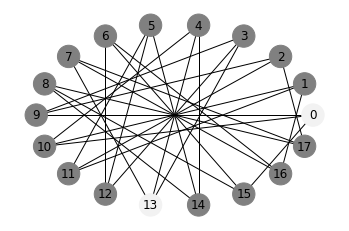

In [386]:
import matplotlib.pyplot as plt

f = plt.figure()
colours = ['grey']*18
colours[0] = '#f2f2f2'
colours[13] = '#f2f2f2'
nx.draw_circular(G,node_color=colours, ax=f.add_subplot(111), node_size=500,with_labels=True)

f.savefig('./data/images/graphene_graph_2v_E.jpg', dpi=300)


In [372]:
colours = ['grey']*18
colours[0] = '#f2f2f2'

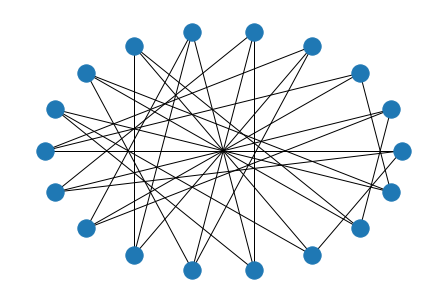

In [260]:
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)